# WSI
## Raport z ćwiczenia laboratoryjnego nr 7
### Jan Kuc, 303753

### 1. Cel eksperymentów

Zadanie polega na implementacji algorytmu naiwnego klasyfikatora Bayesa, a następnie przetestowaniu go na zbiorze danych *Cardio Vascular Disease Detection*. Nalezy równiez sprawdzić jakość klasyfikatora metodami: 
- podziału danych na zbiór trenujący, walidacyjny i testowy,
- k-krotnej walidacji krzyzowej dla róznych wartości k.

In [1]:
import sys
sys.path.append('..')
from src.process_data import process_data, dataset_split, cross_validation_split
from src.my_solver import NaiveBayesSolver

In [2]:
FILENAME = '../data/cardio_train.csv'

In [3]:
CLASS_LABEL = 'cardio'

[[<AxesSubplot:title={'center':'age'}>
  <AxesSubplot:title={'center':'gender'}>
  <AxesSubplot:title={'center':'height'}>]
 [<AxesSubplot:title={'center':'weight'}>
  <AxesSubplot:title={'center':'ap_hi'}>
  <AxesSubplot:title={'center':'ap_lo'}>]
 [<AxesSubplot:title={'center':'cholesterol'}>
  <AxesSubplot:title={'center':'gluc'}>
  <AxesSubplot:title={'center':'smoke'}>]
 [<AxesSubplot:title={'center':'alco'}>
  <AxesSubplot:title={'center':'active'}>
  <AxesSubplot:title={'center':'cardio'}>]]
             Missing Values  % of Total Values
age                       0                0.0
gender                    0                0.0
height                    0                0.0
weight                    0                0.0
ap_hi                     0                0.0
ap_lo                     0                0.0
cholesterol               0                0.0
gluc                      0                0.0
smoke                     0                0.0
alco                      

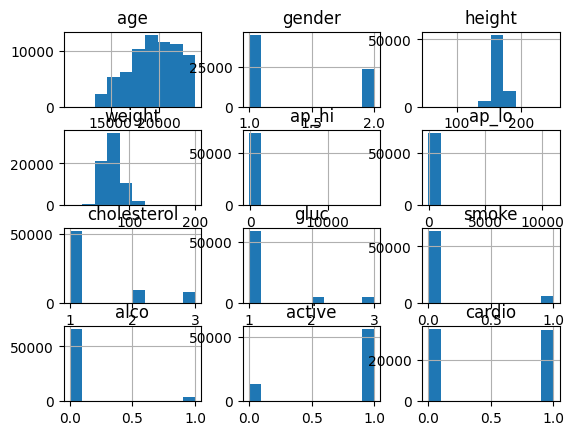

In [4]:
dataset = process_data(FILENAME)

In [5]:
dataset.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,22469,1,155,69.0,130,80,2,2,0,0,1,0
1,14648,1,163,71.0,110,70,1,1,0,0,1,1
2,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,23393,1,155,62.0,120,80,1,1,0,0,1,0


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69301 entries, 0 to 69300
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          69301 non-null  int64  
 1   gender       69301 non-null  int64  
 2   height       69301 non-null  int64  
 3   weight       69301 non-null  float64
 4   ap_hi        69301 non-null  int64  
 5   ap_lo        69301 non-null  int64  
 6   cholesterol  69301 non-null  int64  
 7   gluc         69301 non-null  int64  
 8   smoke        69301 non-null  int64  
 9   alco         69301 non-null  int64  
 10  active       69301 non-null  int64  
 11  cardio       69301 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.3 MB


In [7]:
non_discrete_attrs = ['age', 'weight', 'height', 'ap_hi', 'ap_lo']

In [8]:
dataset[non_discrete_attrs].head()

,age,weight,height,ap_hi,ap_lo
0,22469,69.0,155,130,80
1,14648,71.0,163,110,70
2,21901,70.0,165,120,80
3,14549,85.0,165,120,80
4,23393,62.0,155,120,80


In [9]:
solver = NaiveBayesSolver()

In [10]:
NUM_OF_SPLITS = 10
FOLDS = range(3,10)

In [11]:
tvt_val_accs = {}
for i in range(NUM_OF_SPLITS):
    split = dataset_split(dataset, CLASS_LABEL)
    train_data_X, train_data_y, valid_data_X, valid_data_y, test_data_X, test_data_y = split
    val_accuracy = solver.evaluate(train_data_X, train_data_y, valid_data_X, valid_data_y, non_discrete_attrs, CLASS_LABEL)
    print(f"Split #{i+1}: val_accuracy = {val_accuracy}")
    tvt_val_accs[val_accuracy] = split

Split #1: val_accuracy = 0.5901154401154401
Split #2: val_accuracy = 0.613997113997114
Split #3: val_accuracy = 0.6017316017316018
Split #4: val_accuracy = 0.573953823953824
Split #5: val_accuracy = 0.5759018759018759
Split #6: val_accuracy = 0.5913419913419914
Split #7: val_accuracy = 0.6139249639249639
Split #8: val_accuracy = 0.5822510822510822
Split #9: val_accuracy = 0.6301587301587301
Split #10: val_accuracy = 0.6267676767676768


In [12]:
best_tvt_acc = max(tvt_val_accs.keys())
print(f"Best split for train-validation-test method: {best_tvt_acc}")
best_tvt_split = tvt_val_accs[best_tvt_acc]

Best split for train-validation-test method: 0.6301587301587301


In [13]:
cross_val_accs = {}
for n_fold in FOLDS:
    X_split, y_split, test_X, test_y = cross_validation_split(dataset, CLASS_LABEL, n_fold)
    eval_dict = solver.evaluate_cross_validation(X_split, y_split, non_discrete_attrs, CLASS_LABEL)
    print(f"Folds count: {n_fold}:")
    i = 1
    for val_accuracy in eval_dict.keys():
        print(f"    Split #{i} val_accuracy: {val_accuracy}")
        train_data_X, train_data_y, valid_data_X, valid_data_y = eval_dict[val_accuracy]
        cross_val_accs[val_accuracy] = (train_data_X, train_data_y, valid_data_X, valid_data_y, test_X, test_y)
        i += 1

Folds count: 3:
    Split #1 val_accuracy: 0.6060606060606061
    Split #2 val_accuracy: 0.6128246753246753
    Split #3 val_accuracy: 0.5418290043290044
Folds count: 4:
    Split #1 val_accuracy: 0.5917027417027417
    Split #2 val_accuracy: 0.5691919191919191
    Split #3 val_accuracy: 0.5904761904761905
    Split #4 val_accuracy: 0.5865079365079365
Folds count: 5:
    Split #1 val_accuracy: 0.5709776334776335
    Split #2 val_accuracy: 0.6068722943722944
    Split #3 val_accuracy: 0.5928932178932179
    Split #4 val_accuracy: 0.58757215007215
    Split #5 val_accuracy: 0.5981240981240982
Folds count: 6:
    Split #1 val_accuracy: 0.5922077922077922
    Split #2 val_accuracy: 0.5890692640692641
    Split #3 val_accuracy: 0.577922077922078
    Split #4 val_accuracy: 0.5773809523809523
    Split #5 val_accuracy: 0.5397186147186147
    Split #6 val_accuracy: 0.5836580086580087
Folds count: 7:
    Split #1 val_accuracy: 0.5739898989898989
    Split #2 val_accuracy: 0.578030303030303
    

In [14]:
best_cross_acc = max(cross_val_accs.keys())
print(f"Best split for cross-validation method: {best_tvt_acc}")
best_cross_split = cross_val_accs[best_cross_acc]

Best split for cross-validation method: 0.6301587301587301


In [23]:
(
    best_train_X,
    best_train_y,
    best_valid_X,
    best_valid_y,
    best_test_X,
    best_test_y,
) = best_tvt_split

best_tvt_test_accuracy = solver.evaluate(
    best_train_X,
    best_train_y,
    best_test_X,
    best_test_y,
    non_discrete_attrs,
    CLASS_LABEL,
)

print(f"Best test accuracy (train-val-test method): {best_tvt_test_accuracy}")

Best test accuracy (train-val-test method): 0.6452636894884929


In [22]:
(
    best_train_X,
    best_train_y,
    best_valid_X,
    best_valid_y,
    best_test_X,
    best_test_y,
) = best_cross_split

best_cross_test_accuracy = solver.evaluate(
    best_train_X,
    best_train_y,
    best_test_X,
    best_test_y,
    non_discrete_attrs,
    CLASS_LABEL,
)

print(f"Best test accuracy (cross-validation method): {best_cross_test_accuracy}")

Best test accuracy (cross-validation method): 0.6058004472981747
